# About this Notebook

This notebook should work whenever the FOM depends on two variables (t, x) and whenever the parameter vector, $\theta$, has two elements (there are two parameters). If your example does not fall into that category, use another notebook!

# Training 

First, let us train a higher-order LaSDI model on the Burgers' equation data. 
If you want to load a pre-trained model from a save, go to the next cell. 

12:43:13.590 - Initialize:Initialize_Trainer:116 - INFO - Initializing Trainer (gplasdi)
12:43:13.590 - Initialize:Initialize_Trainer:116 - INFO - Initializing Trainer (gplasdi)
12:43:13.590 - Initialize:Initialize_Trainer:116 - INFO - Initializing Trainer (gplasdi)
12:43:13.591 - ParameterSpace:__init__:193 - INFO - Initializing a ParameterSpace object with parameters ['a', 'w']
12:43:13.591 - ParameterSpace:__init__:193 - INFO - Initializing a ParameterSpace object with parameters ['a', 'w']
12:43:13.591 - ParameterSpace:__init__:193 - INFO - Initializing a ParameterSpace object with parameters ['a', 'w']
12:43:13.593 - ParameterSpace:__init__:201 - INFO - The testing set has 25 parameter combinations
12:43:13.593 - ParameterSpace:__init__:201 - INFO - The testing set has 25 parameter combinations
12:43:13.593 - ParameterSpace:__init__:201 - INFO - The testing set has 25 parameter combinations
12:43:13.594 - ParameterSpace:__init__:208 - INFO - The training set has 4 parameter combin

Function name      	Calls	Total time	Time/call

Rollout Setup      	2005	3.329e+00	1.660e-03

train_step         	500	4.531e+01	9.061e-02

Forward Pass       	2000	5.468e+00	2.734e-03

Reconstruction Loss	2000	7.564e-01	3.782e-04

Consistency Loss   	2000	1.437e+00	7.187e-04

Chain Rule Loss    	2000	7.188e+00	3.594e-03

Calibration        	500	9.889e-01	1.978e-03

Rollout Loss       	500	5.908e+00	1.182e-02

Backwards Pass     	500	1.916e+01	3.833e-02

Report             	500	5.349e-01	1.070e-03

finalize           	1	2.580e-03	2.580e-03

Plotting testing parameter combination number 15 (['a', 'w'] = [1.05 0.9 ])


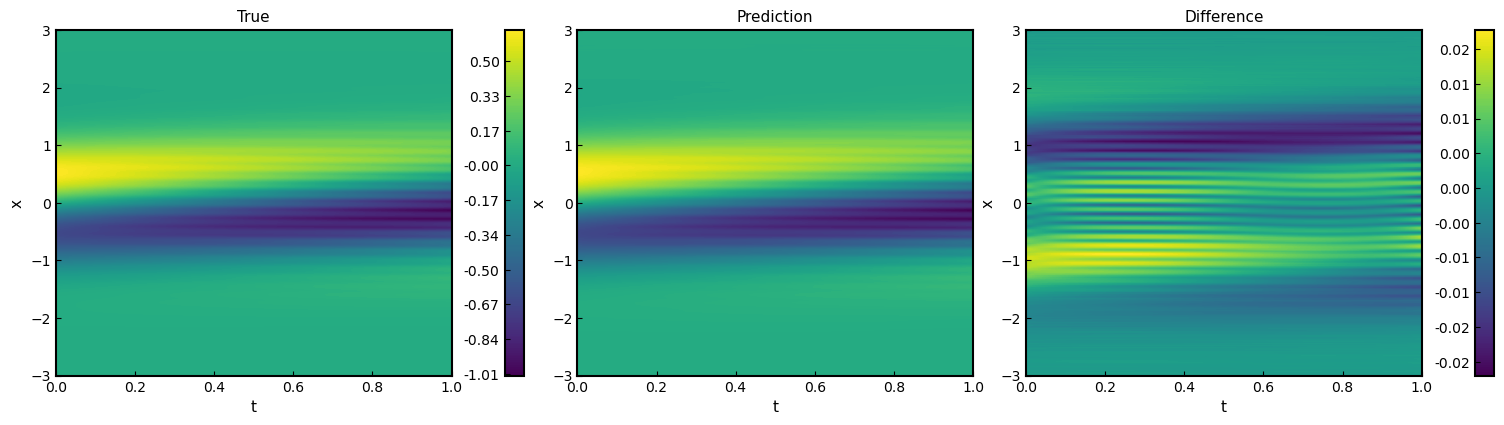

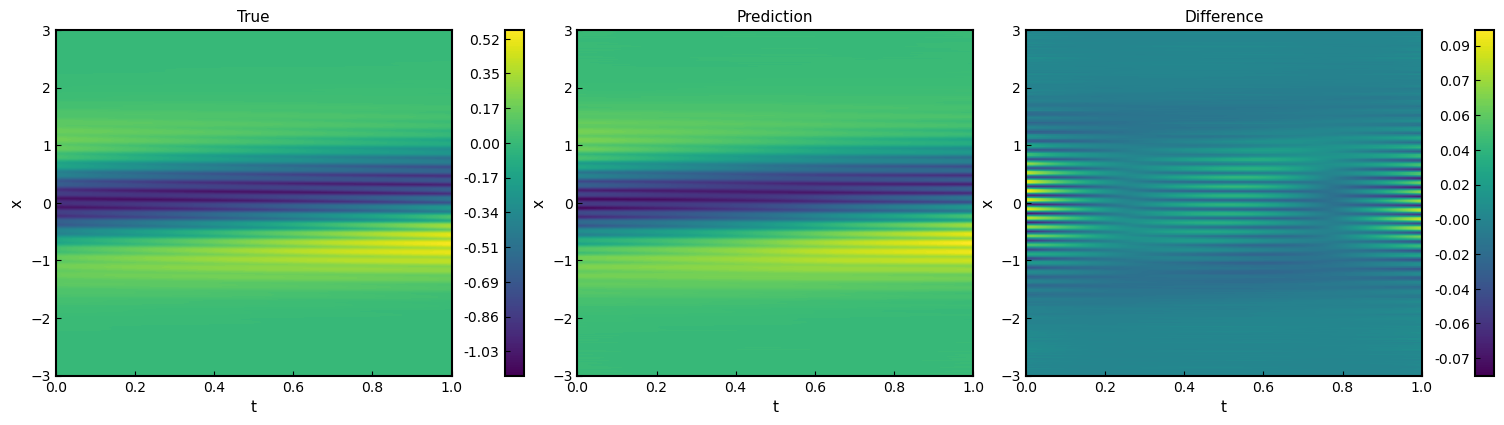

12:44:04.375 - GPLaSDI:get_new_sample_point:976 - INFO - 
~~~~~~~ Finding New Point ~~~~~~~
12:44:04.375 - GPLaSDI:get_new_sample_point:976 - INFO - 
~~~~~~~ Finding New Point ~~~~~~~
12:44:04.375 - GPLaSDI:get_new_sample_point:976 - INFO - 
~~~~~~~ Finding New Point ~~~~~~~
/Users/stephany1/Documents/Projects/Higher Order LaSDI/src/GPLaSDI.py:984: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add

Function name      	Calls	Total time	Time/call

Rollout Setup      	4511	7.716e+00	1.710e-03

train_step         	1000	1.096e+02	1.096e-01

Forward Pass       	4500	1.226e+01	2.725e-03

Reconstruction Loss	4500	1.772e+00	3.937e-04

Consistency Loss   	4500	3.206e+00	7.125e-04

Chain Rule Loss    	4500	1.635e+01	3.633e-03

Calibration        	1000	2.181e+00	2.181e-03

Rollout Loss       	1000	1.662e+01	1.662e-02

Backwards Pass     	1000	4.697e+01	4.697e-02

Report             	1000	1.098e+00	1.098e-03

finalize           	2	5.336e-03	2.668e-03

new_sample         	1	1.159e+01	1.159e+01



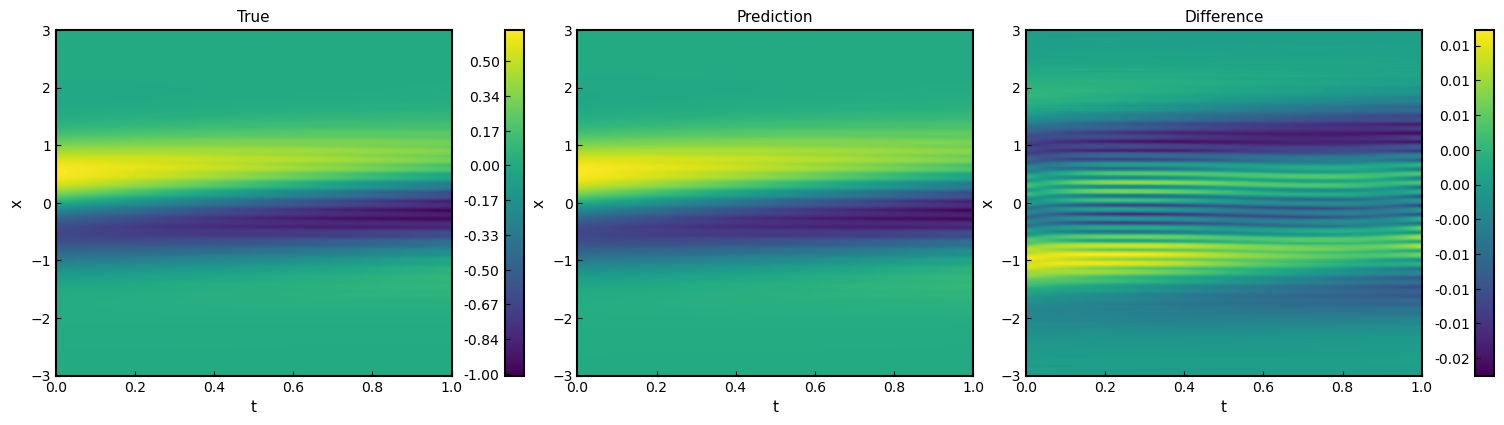

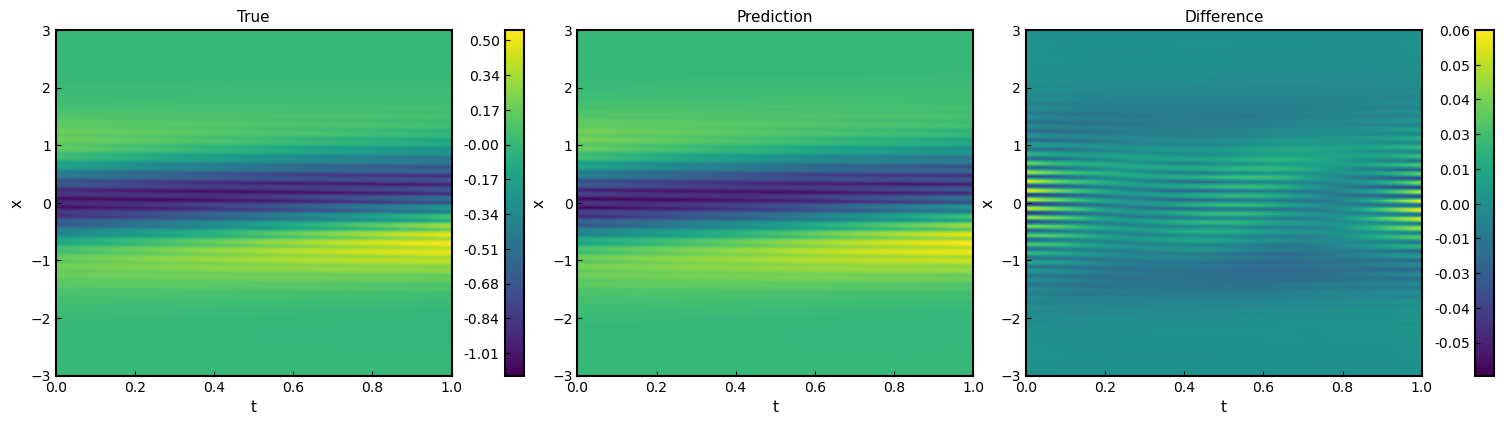

In [3]:
# -------------------------------------------------------------------------------------------------
# Imports 
# -------------------------------------------------------------------------------------------------

import  os;
import  sys;

src_path    : str = os.path.join(os.path.abspath(os.path.pardir), "src");
utils_path  : str = os.path.join(src_path, "Utilities");
sys.path.append(src_path);
sys.path.append(utils_path);

import  random;
import  yaml;
import  logging;

import  torch
import  numpy;

from    Workflow    import  Save;
from    Enums       import  NextStep, Result;
from    Sample      import  Run_Samples, Update_Train_Space;
from    Initialize  import  Initialize_Trainer;
from    Logging     import  Initialize_Logger, Log_Dictionary;
from    Plot        import  Plot_Reconstruction;



# -------------------------------------------------------------------------------------------------
# Setup
# -------------------------------------------------------------------------------------------------

# Set up the logger
Initialize_Logger(logging.INFO);
LOGGER  : logging.Logger    = logging.getLogger(__name__);

# Load the configuration.
cfg_file : str = 'Explicit.yml';
#cfg_file : str = 'Burgers.yml';
with open(cfg_file, 'r') as f:
    config : dict = yaml.safe_load(f);
Log_Dictionary(LOGGER = LOGGER, D = config, level = logging.DEBUG);

# Setup the trainer
trainer, param_space, physics, model, latent_dynamics = Initialize_Trainer(config);



# -------------------------------------------------------------------------------------------------
# Train
# -------------------------------------------------------------------------------------------------

LOGGER.info("Training with %d epochs" % trainer.max_iter);

# generate initial training/test data
Run_Samples(trainer, config);



# Fetch the number of testing, training examples.
n_train : int   = param_space.n_train();
n_test  : int   = param_space.n_test();
n_IC    : int   = latent_dynamics.n_IC;

# initial training given training data
trainer.train();


# Select a random parameter combination to investigate.
index_plot  : int = random.randrange(0, n_test);
print("Plotting testing parameter combination number %d (%s = %s)" % (index_plot, str(param_space.param_names), str(param_space.test_space[index_plot, :])));

Plot_Reconstruction(
    X_True  = trainer.X_Test[index_plot],
    model   = trainer.model, 
    t_grid  = trainer.t_Test[index_plot].numpy(), 
    x_grid  = trainer.physics.X_Positions);


while (trainer.restart_iter < trainer.max_iter):
    if (trainer.restart_iter <= trainer.max_greedy_iter):
        # perform greedy sampling to pick up new samples
        Update_Train_Space(trainer, config);
        # update training data with newly picked samples
        Run_Samples(trainer, config);

    # train over given training data
    trainer.train();

    # Plot 
    Plot_Reconstruction(  
        X_True  = trainer.X_Test[index_plot],
        model   = trainer.model, 
        t_grid  = trainer.t_Test[index_plot].numpy(), 
        x_grid  = trainer.physics.X_Positions);


# Finally, save!
Save(   param_space         = param_space, 
        physics             = physics, 
        model               = model, 
        latent_dynamics     = latent_dynamics, 
        trainer             = trainer, 
        next_step           = NextStep.PickSample, 
        result              = Result.Success,
        restart_filename    = None);

# Loading From a Save


If you instead want to load a saved model, we can load the restart file for post-training.

In [2]:
# Add src directory to the search path
import  os;
import  sys;
src_path    : str = os.path.join(os.path.abspath(os.path.pardir), "src");
sys.path.append(src_path);

import  yaml;
import  logging;

import  numpy; 
import  torch;

from    ParameterSpace  import  ParameterSpace;
from    Initialize      import  Initialize_Trainer;



# Specify the restart file you have.
filename    : str   = 'lasdi_04_30_2025_17_32.npy'
cfg_file    : str   = 'Explicit.yml'
with open(cfg_file, 'r') as f:
    config = yaml.safe_load(f)

file_path   : str   = os.path.join(os.path.join(os.path.pardir, "results"), filename);
restart_file        = numpy.load(file_path, allow_pickle = True).item()

trainer, param_space, physics, model, latent_dynamics = Initialize_Trainer(config, restart_file)

12:42:59.362 - Initialize:Initialize_Trainer:116 - INFO - Initializing Trainer (gplasdi)
12:42:59.362 - Initialize:Initialize_Trainer:116 - INFO - Initializing Trainer (gplasdi)
12:42:59.362 - ParameterSpace:__init__:193 - INFO - Initializing a ParameterSpace object with parameters ['a', 'w']
12:42:59.362 - ParameterSpace:__init__:193 - INFO - Initializing a ParameterSpace object with parameters ['a', 'w']
12:42:59.363 - ParameterSpace:__init__:201 - INFO - The testing set has 25 parameter combinations
12:42:59.363 - ParameterSpace:__init__:201 - INFO - The testing set has 25 parameter combinations
12:42:59.364 - ParameterSpace:__init__:208 - INFO - The training set has 4 parameter combinations
12:42:59.364 - ParameterSpace:__init__:208 - INFO - The training set has 4 parameter combinations
12:42:59.364 - Initialize:Initialize_Physics:262 - INFO - Initializing Physics (Explicit)
12:42:59.364 - Initialize:Initialize_Physics:262 - INFO - Initializing Physics (Explicit)
12:42:59.365 - Mod

# Post-processing

Setup data for post-processing:

In [4]:
n_coef          : int                       = latent_dynamics.n_coefs;
n_IC            : int                       = latent_dynamics.n_IC; 
n_p             : int                       = param_space.n_p; 

coefs           : numpy.ndarray             = trainer.best_coefs;           # shape = (n_train, n_coefs).
X_Train         : list[list[torch.Tensor]]  = trainer.X_Train;              # len = n_train. i'th element is a list of length n_IC. j'th element has length (n_t(i), n_x); holds j'th derivative of i'th FOM train solve
X_Test          : list[list[torch.Tensor]]  = trainer.X_Test;               # len = n_test. i'th element is a list of length n_IC. j'th element has length (n_t(i), n_x); holds j'th derivative of i'th FOM test solve.
t_Train         : list[torch.Tensor]        = trainer.t_Train;              # len = n_train. i'th element is a numpy.ndarray of shape (n_t(i)) whose j'th element holds the j'th time value for the i'th FOM train solve.
t_Test          : list[torch.Tensor]        = trainer.t_Test;               # len = n_test. i'th element is a numpy.ndarray of shape (n_t(i)) whose j'th element holds the j'th time value for the i'th FOM test solve.
n_samples       : int                       = trainer.n_samples;

param_train     : numpy.ndarray             = param_space.train_space;      # shape = (n_train, n_p)
param_test      : numpy.ndarray             = param_space.test_space;       # shape = (n_test, n_p)
param_names     : list[str]                 = param_space.param_names;

test_meshgrid   : tuple[numpy.ndarray]      = param_space.test_meshgrid;    # len = n_p. i'th element is meshgrid for i'th parameter.
test_grid_sizes : list[int]                 = param_space.test_grid_sizes;  # len = n_p. i'th element holds the number of values of the i'th parameter in the test set.
n_init_train    : int                       = param_space.n_init_train;     # The initial number of combinations of parameters in the training set.
n_train         : int                       = param_space.n_train();
n_test          : int                       = param_space.n_test();

X_Positions     : numpy.ndarray             = physics.X_Positions;          # Spatial discretization of FOM problem domain.
assert(X_Positions.ndim == 1);


## Gaussian-process uncertainty evaluation
For each combination of parameters, evaluate the coefficient GPs to generate a set of coefficients for the latent dynamics for that parameter combination. Then solve each latent dynamics forward in time.

In [14]:
# First, we need to import a few new things.
import os;
import sys;
physics_path    : str   = os.path.join(os.path.join(os.path.pardir, "src"), "Physics");
utils_path      : str   = os.path.join(os.path.join(os.path.pardir, "src"), "Utilities");
sys.path.append(physics_path);

from    sklearn.gaussian_process    import  GaussianProcessRegressor;

import  SolveROMs;
import  GaussianProcess;
from    Physics                     import  Physics;
from    Model                       import  Autoencoder, Autoencoder_Pair;

# Setup
model.cpu();

# Get a GP for each coefficient in the latent dynamics.
gp_list         : list[GaussianProcessRegressor]    = GaussianProcess.fit_gps(param_space.train_space, coefs);

# Get the mean and std of each coefficient's distribution when we evaluate the posterior coefficient 
# distributions at each testing parameter value. We then reshape these arrays to have shape 
# (N(1), ... , N(n_p)), where N(k) is the number of distinct values of the k'th parameter in the 
# training set. The i(1), ... , i(n_p), j element of the d'th element of these lists will hold the 
# mean and std of the distribution of the j'th parameter when we use the i(k)'th value of the k'th 
# parameter.
gp_pred_mean, gp_pred_std = GaussianProcess.eval_gp(gp_list, param_test);
gp_pred_mean    = gp_pred_mean.reshape(test_grid_sizes + [-1]);
gp_pred_std     = gp_pred_std.reshape(test_grid_sizes + [-1]);


# Get the maximum std and relative error for each combination of parameter values in the testing set.
max_rel_error, max_std = SolveROMs.Compute_Error_and_STD(   model           = model, 
                                                            physics         = physics, 
                                                            param_space     = param_space, 
                                                            latent_dynamics = latent_dynamics, 
                                                            gp_list         = gp_list, 
                                                            t_Test          = t_Test, 
                                                            X_Test          = X_Test, 
                                                            n_samples       = n_samples);

/Users/stephany1/miniconda3/envs/LaSDI/lib/python3.10/site-packages/sklearn/gaussian_process/kernels.py:442: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__length_scale is close to the specified lower bound 0.1. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/Users/stephany1/miniconda3/envs/LaSDI/lib/python3.10/site-packages/sklearn/gaussian_process/kernels.py:442: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__length_scale is close to the specified lower bound 0.1. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/Users/stephany1/miniconda3/envs/LaSDI/lib/python3.10/site-packages/sklearn/gaussian_process/kernels.py:442: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__length_scale is close to the specified lower bound 0.1. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/Users/stephany1/mi

# Visualization

Plot mean and standard deviation of coefficient matrix.

13:11:38.829 - Plot:Plot_GP2d:516 - INFO - Producing GP plots with 55 coefficients. The parameters are ['a', 'w']
13:11:38.829 - Plot:Plot_GP2d:516 - INFO - Producing GP plots with 55 coefficients. The parameters are ['a', 'w']
13:11:38.829 - Plot:Plot_GP2d:516 - INFO - Producing GP plots with 55 coefficients. The parameters are ['a', 'w']


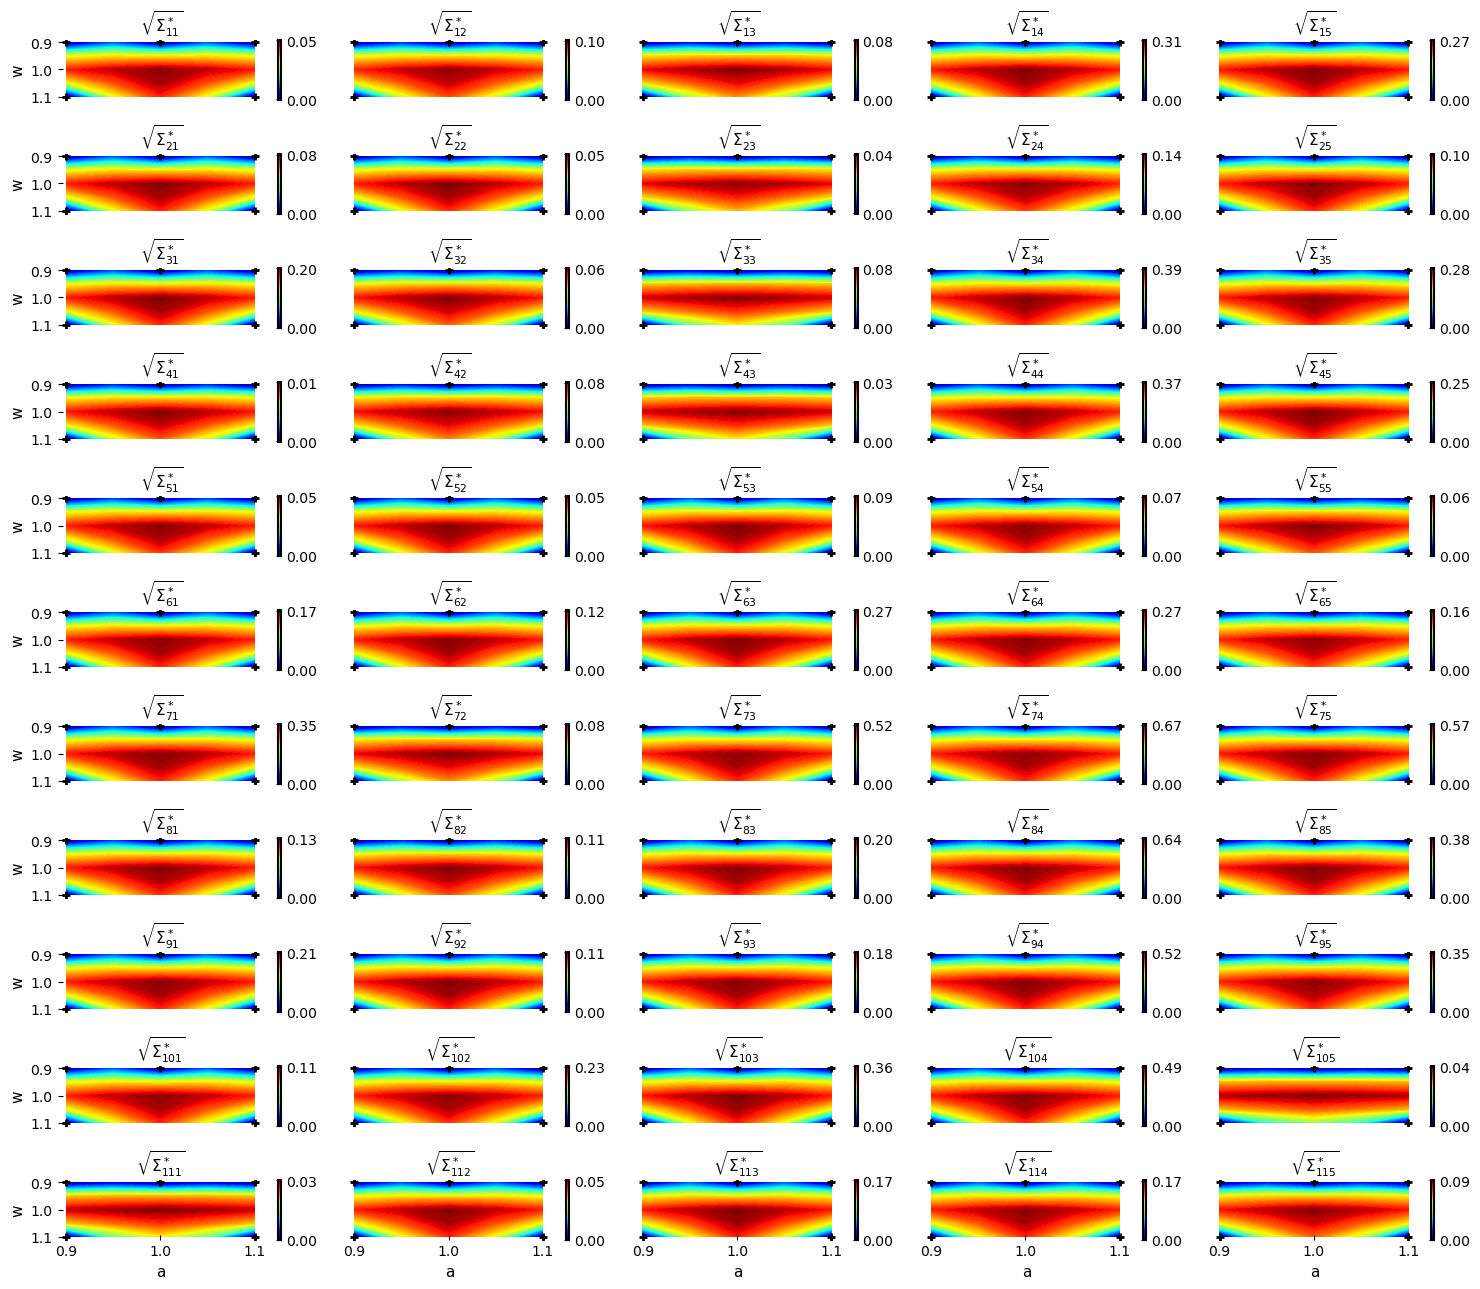

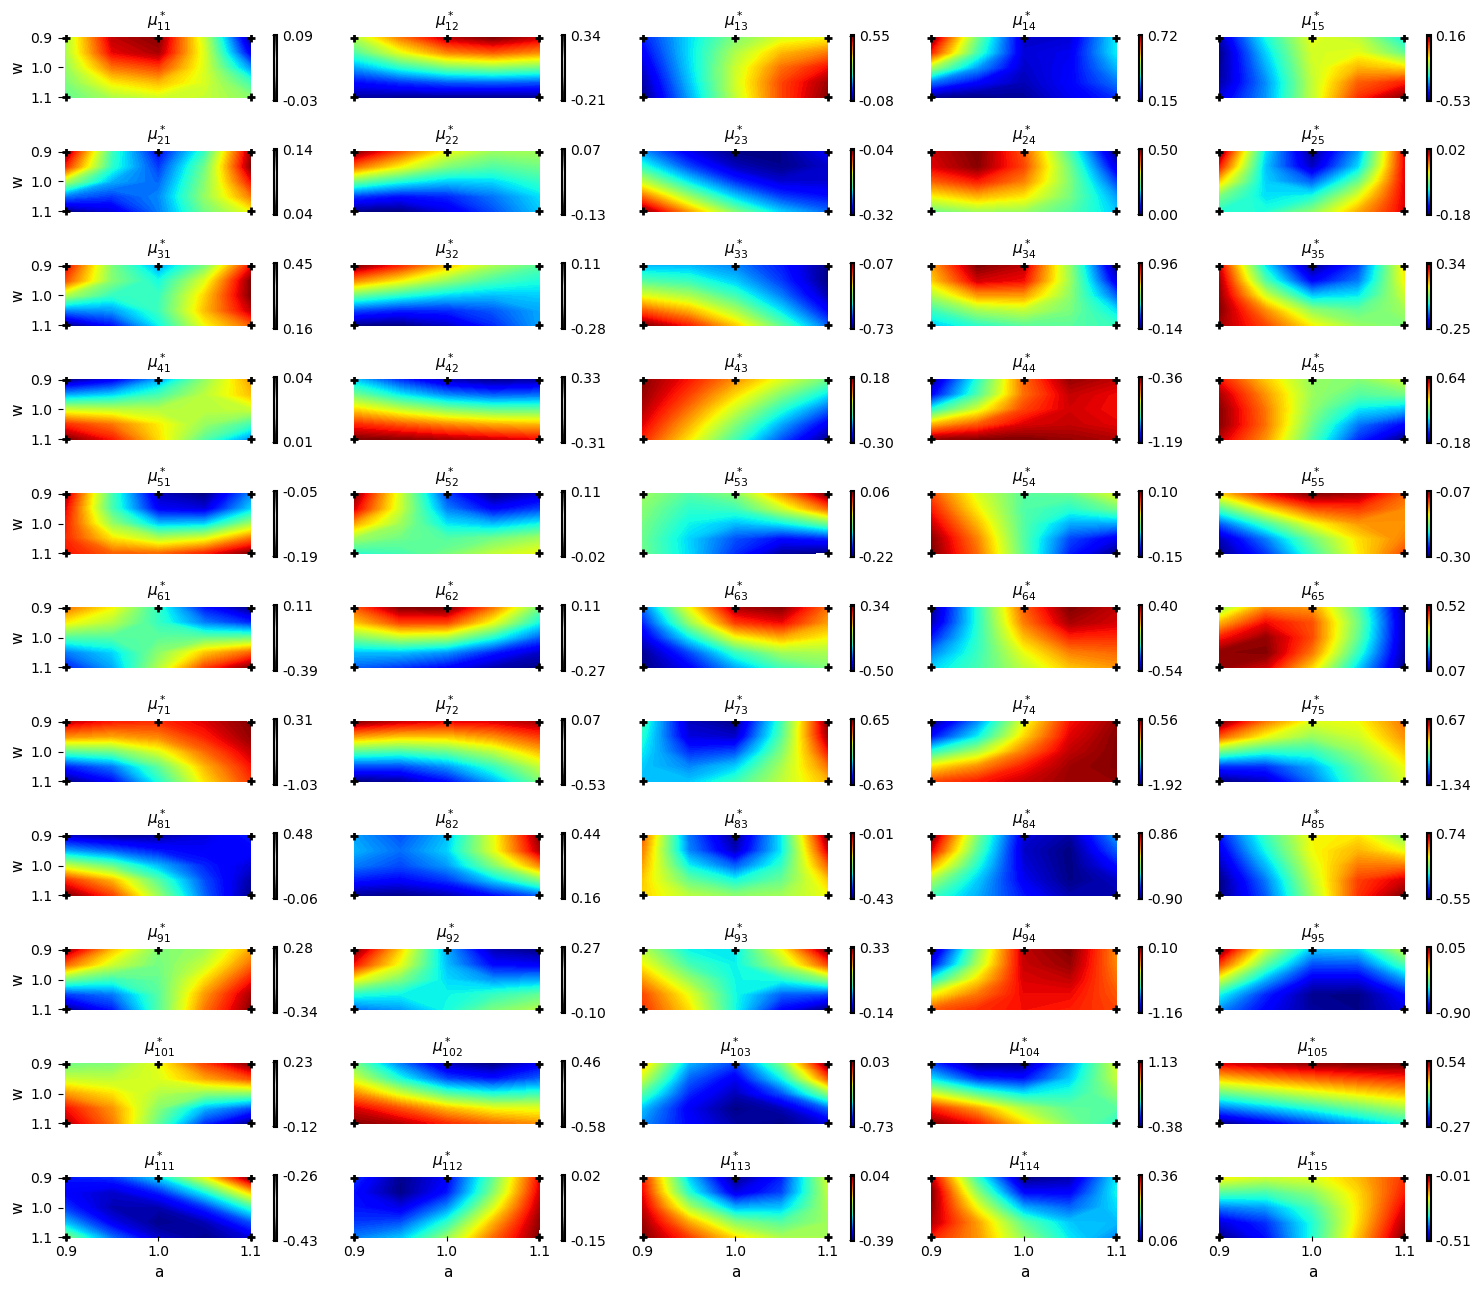

In [15]:
import  Plot;


if(n_p == 2):
    Plot.Plot_GP2d( p1_mesh     = test_meshgrid[0], 
                    p2_mesh     = test_meshgrid[1], 
                    gp_mean     = gp_pred_mean, 
                    gp_std      = gp_pred_std, 
                    param_train = param_train, 
                    param_names = param_names, 
                    n_cols      = 5);

15:08:31.754 - Plot:Plot_Heatmap2d:692 - INFO - Making heatmap. Parameters = ['a', 'w']. There are 5 training points (4 initial) and 25 testing points.
15:08:31.754 - Plot:Plot_Heatmap2d:692 - INFO - Making heatmap. Parameters = ['a', 'w']. There are 5 training points (4 initial) and 25 testing points.
15:08:31.754 - Plot:Plot_Heatmap2d:692 - INFO - Making heatmap. Parameters = ['a', 'w']. There are 5 training points (4 initial) and 25 testing points.


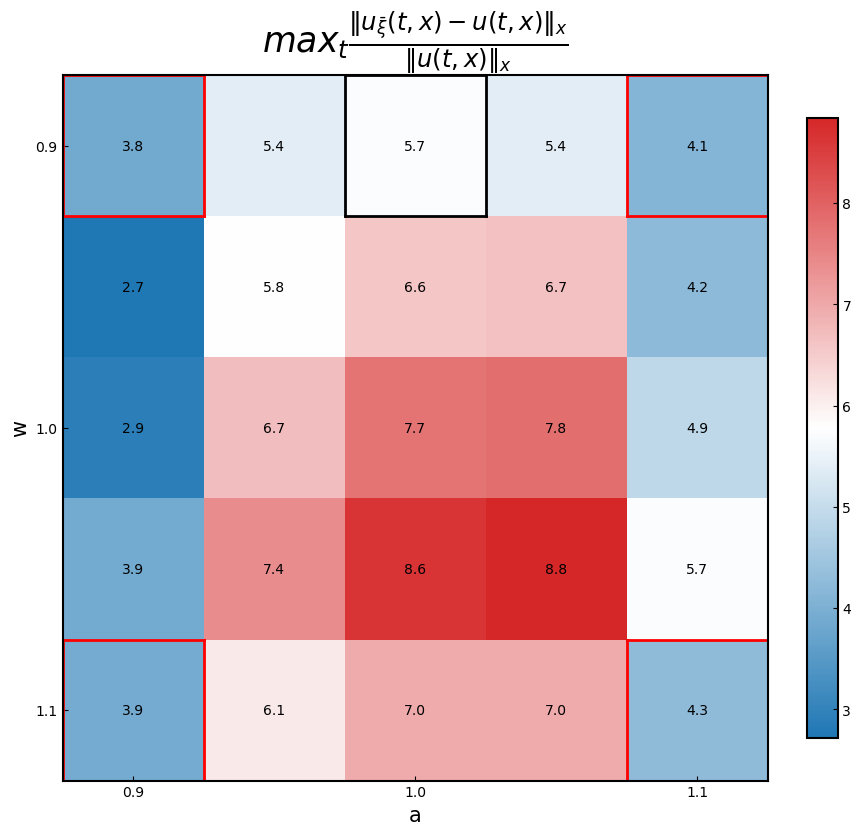

15:08:31.861 - Plot:Plot_Heatmap2d:692 - INFO - Making heatmap. Parameters = ['a', 'w']. There are 5 training points (4 initial) and 25 testing points.
15:08:31.861 - Plot:Plot_Heatmap2d:692 - INFO - Making heatmap. Parameters = ['a', 'w']. There are 5 training points (4 initial) and 25 testing points.
15:08:31.861 - Plot:Plot_Heatmap2d:692 - INFO - Making heatmap. Parameters = ['a', 'w']. There are 5 training points (4 initial) and 25 testing points.


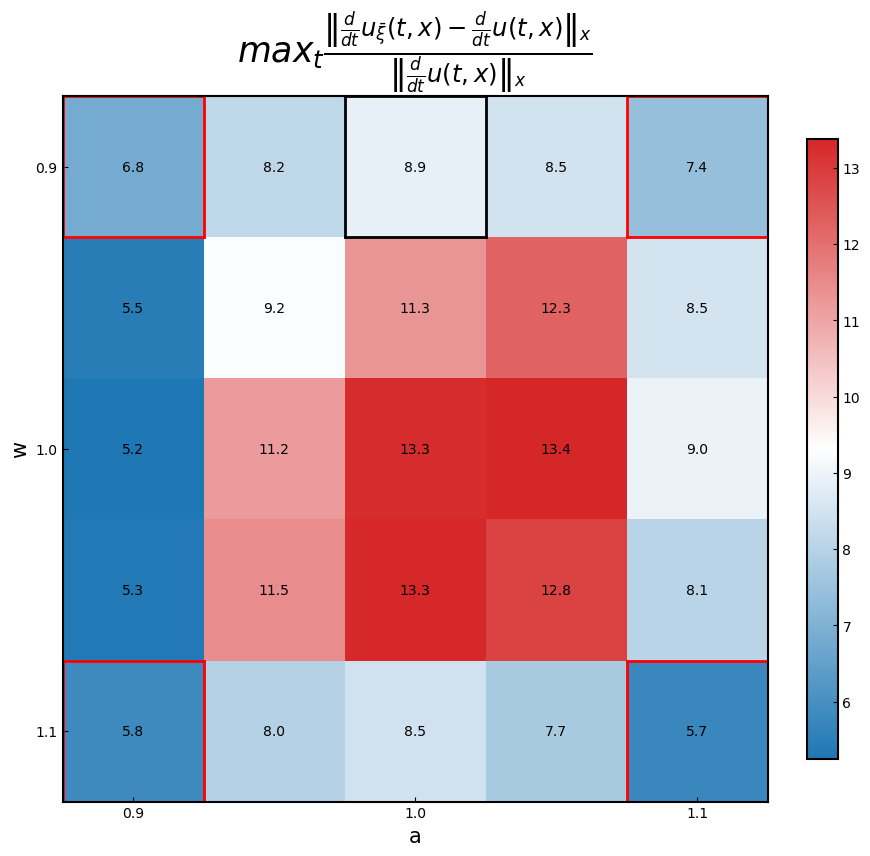

In [31]:
for d in range(n_IC):
    if(d == 0):
        title   : str   = r'$max_{t} \frac{\left\| u_\bar{\xi}(t, x) - u(t, x) \right\|_x} {\| u(t, x)\|_x}$';
    elif(d == 1):
        title   : str   = r'$max_{t} \frac{\left\| \frac{d}{dt}u_{\bar{\xi}}(t, x) - \frac{d}{dt}u(t, x) \right\|_x}{\left\| \frac{d}{dt}u(t, x) \right\|_x}$';
    else:
        title   : str   = r'$max_{t} \frac{\left\| \frac{d^{%d}}{dt^{%d}}u_{\bar{\xi}}(t, x) - \frac{d^{%d}}{dt^{%d}}u(t, x) \right\|_x}{\left\| \frac{d^{%d}}{dt^{%d}}u(t, x) \right\|_x}$' % (d, d, d, d, d, d);

    Plot.Plot_Heatmap2d(values          = max_rel_error[d] * 100, 
                        param_space     = param_space,
                        title           = title);

15:08:18.429 - Plot:Plot_Heatmap2d:692 - INFO - Making heatmap. Parameters = ['a', 'w']. There are 5 training points (4 initial) and 25 testing points.
15:08:18.429 - Plot:Plot_Heatmap2d:692 - INFO - Making heatmap. Parameters = ['a', 'w']. There are 5 training points (4 initial) and 25 testing points.
15:08:18.429 - Plot:Plot_Heatmap2d:692 - INFO - Making heatmap. Parameters = ['a', 'w']. There are 5 training points (4 initial) and 25 testing points.


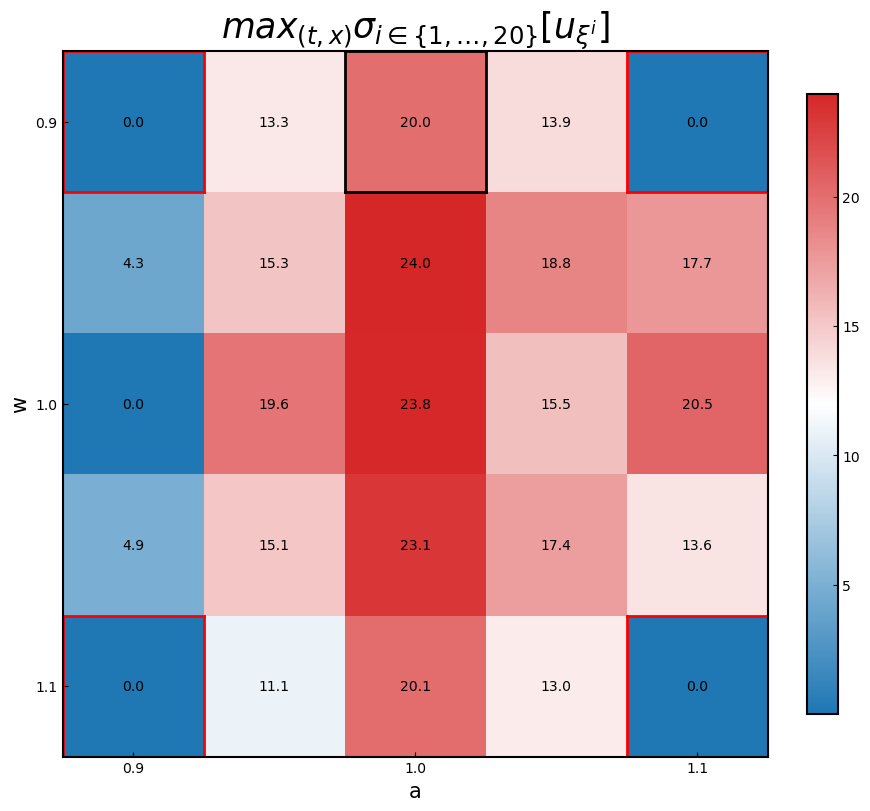

15:08:18.538 - Plot:Plot_Heatmap2d:692 - INFO - Making heatmap. Parameters = ['a', 'w']. There are 5 training points (4 initial) and 25 testing points.
15:08:18.538 - Plot:Plot_Heatmap2d:692 - INFO - Making heatmap. Parameters = ['a', 'w']. There are 5 training points (4 initial) and 25 testing points.
15:08:18.538 - Plot:Plot_Heatmap2d:692 - INFO - Making heatmap. Parameters = ['a', 'w']. There are 5 training points (4 initial) and 25 testing points.


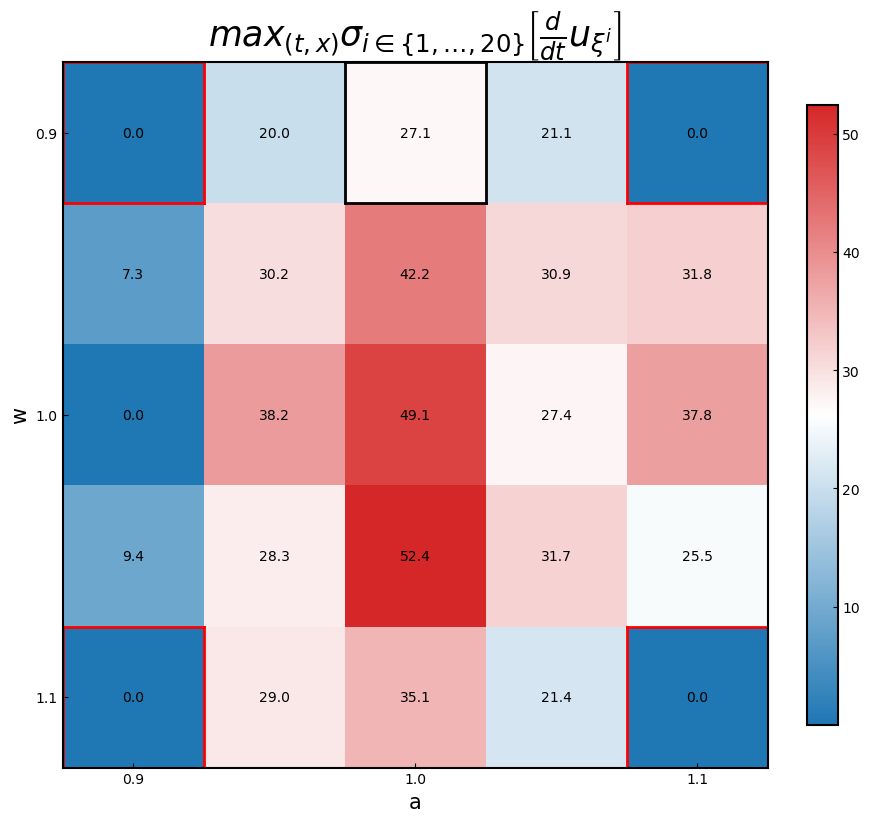

In [30]:
import Plot; 

for d in range(n_IC):
    if(d == 0):
        title   : str   = r'$max_{(t, x)} \sigma_{i \in \{1, \ldots, %d\}} \left[ u_{\xi^i} \right]$' % trainer.n_samples;
    elif(d == 1):
        title   : str   = r'$max_{(t, x)} \sigma_{i \in \{ 1, \ldots, %d\}} \left[\frac{d}{dt}u_{\xi^i} \right]$' % (trainer.n_samples);
    else:
        title   : str   = r'$max_{(t, x)} \sigma_{i \in \{ 1, \ldots, %d\}} \left[\frac{d^{%d}}{dt^{%d}}u_{\xi^i} \right]$' % (trainer.n_samples, d, d);



    Plot.Plot_Heatmap2d(values          = max_std[d] * 100,
                        param_space     = param_space, 
                        title           = title);

13:47:07.590 - Plot:Plot_Prediction:282 - INFO - Solving the latent dynamics using 20 samples of the posterior distributions for 1 combinations of parameter values
13:47:07.590 - Plot:Plot_Prediction:282 - INFO - Solving the latent dynamics using 20 samples of the posterior distributions for 1 combinations of parameter values
13:47:07.590 - Plot:Plot_Prediction:282 - INFO - Solving the latent dynamics using 20 samples of the posterior distributions for 1 combinations of parameter values
13:47:07.598 - SolveROMs:sample_roms:286 - INFO - Generating latent trajectories for 20 samples of the coefficients.
13:47:07.598 - SolveROMs:sample_roms:286 - INFO - Generating latent trajectories for 20 samples of the coefficients.
13:47:07.598 - SolveROMs:sample_roms:286 - INFO - Generating latent trajectories for 20 samples of the coefficients.
13:47:07.948 - Plot:Plot_Prediction:317 - INFO - Computing mean/std of predictions for combination number 0.
13:47:07.948 - Plot:Plot_Prediction:317 - INFO -

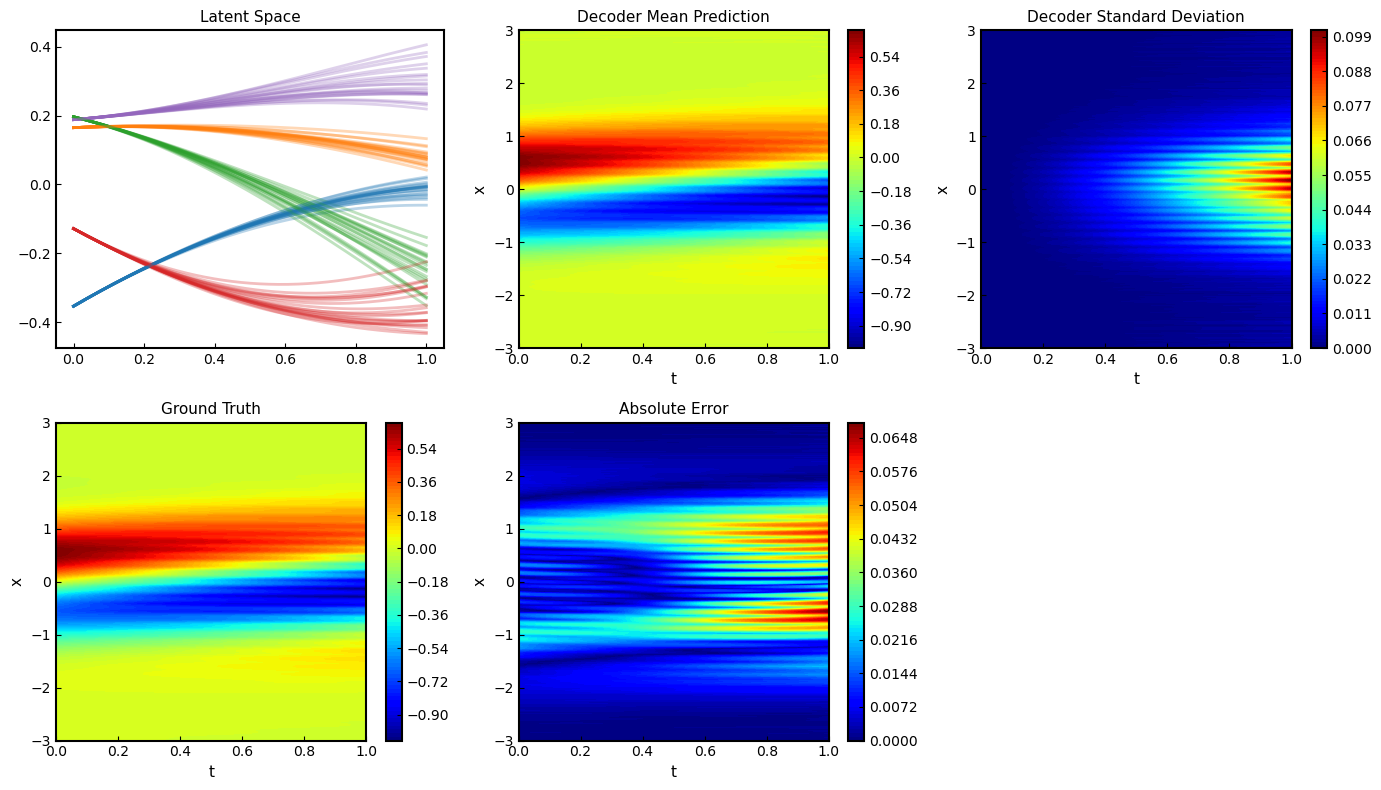

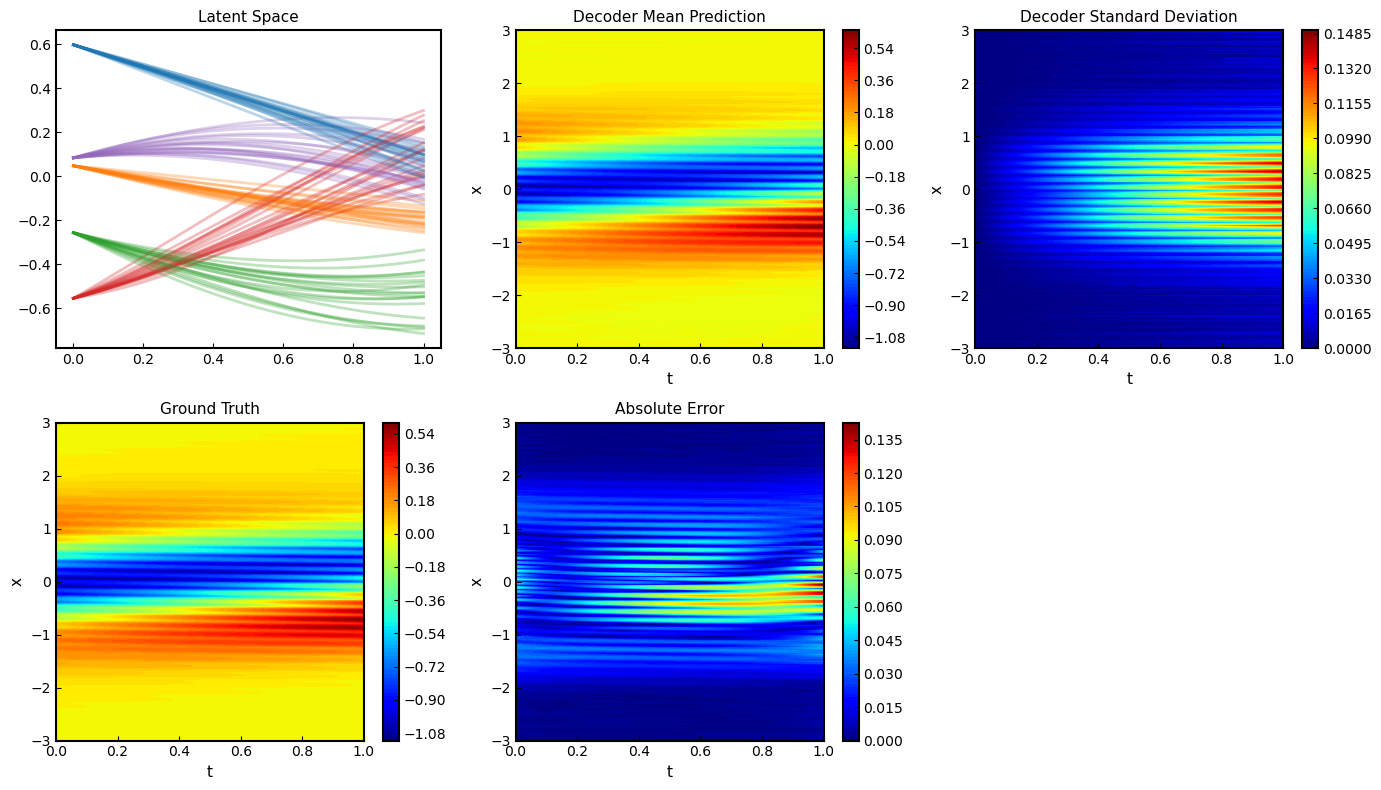

In [29]:
import importlib
importlib.reload(Plot);

# Pick some parameter values.
a           : float                 = 0.9;
w           : float                 = 1.07; 
param_grid  : numpy.ndarray         = numpy.array([[a, w]]);

# Get the predicted solution using this parameter value.
X_True, t_Grid = physics.solve(param_grid[0]);


# Plot the predictions!
Plot.Plot_Prediction(
            model           = model, 
            physics         = physics, 
            latent_dynamics = latent_dynamics, 
            param_grid      = param_grid,
            gp_list         = gp_list, 
            n_samples       = n_samples, 
            X_True          = [X_True], 
            t_Grid          = [t_Grid]);
